# Comparing RB Analysis Tools Under Different Noise Models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sbn

import pystan as ps
import numpy as np
import scipy.stats as st
import utils as su

# whether or not to overwrite existing plots when exporting them
su.overwrite = True

## Data Generation

Function to load in the simulated survival probabilities from Mathematica's output (`survival-distributions.nb`), and use it to simulate some bernoulli trials.

In [2]:
def generate_data(survivals_file, Nbin=30, Nsamp=20):
    rbd = su.RBSimData(survivals_file)
    survivals = rbd.survival_data[:,0,:,0]

    mlist = rbd.sequence_lengths
    Nm = mlist.size

    datavals = np.empty((Nm, Nsamp), dtype='int')
    for idx_m, m in enumerate(mlist):
        p = np.clip(survivals[idx_m,:Nsamp],0,1)
        datavals[idx_m,:] = np.random.binomial(Nbin,p)

    data = su.rb_lsf_completion(
        dict(
            Nm=Nm, Nsamp=Nsamp, Nbin=Nbin, Nc=10,
            m=mlist,
            Q=datavals,
            d=2,
            fname=survivals_file
        ),
       method=su.rb_lsf
    )
    return data

## Dirichlet Process based Stan Model

Load the CDPBM stan model. We use a wrapping class that caches these compiled models to disk, so the first time it loads will take the longest.

In [3]:
model_dp = su.StanModelFactory('./stan/rb-dp.stan').model

Generate data from each of the three noise models and fit to it.

In [4]:
data_dep = generate_data('../data/depolarizing_model_survivals.h5')
fname = data_dep['fname']; data_dep.pop('fname')
fit_dep = model_dp.sampling(data=data_dep, iter=500, chains=4, control=dict(adapt_delta=0.95))
data_dep['fname'] = fname

In [5]:
data_over = generate_data('../data/overrotation_model_survivals.h5')
fname = data_over['fname']; data_over.pop('fname')
fit_over = model_dp.sampling(data=data_over, iter=500, chains=4, control=dict(adapt_delta=0.95))
data_over['fname'] = fname

In [6]:
data_od = generate_data('../data/overrotation_and_dephasing_model_survivals.h5')
fname = data_od['fname']; data_od.pop('fname')
fit_od = model_dp.sampling(data=data_od, iter=500, chains=4, control=dict(adapt_delta=0.95))
data_od['fname'] = fname

In [9]:
def survival_dist_plot(fit, data, m=5000, surv_color='b', surv_hatch=''):
    idx_m = int(np.arange(data['Nm'])[data['m'] == m])

    w = fit.extract()['w'][:,idx_m,np.newaxis,:]
    nu = fit.extract()['nu'][:,idx_m,np.newaxis,:]
    r = fit.extract()['r'][:,idx_m,np.newaxis,:]
    a = 1 / (r - r * nu) - nu
    b = 1 / (r * nu) - 1 + nu

    x_plot = np.linspace(0,1,200)
    post_pmfs = np.sum(w * st.beta.pdf(np.atleast_3d(x_plot), a, b), axis=2)
    post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)
    plt.fill_between(x_plot, post_pmf_low, post_pmf_high, color='gray', alpha=0.5, zorder=50, label='%95 credible region')
    plt.plot(x_plot, post_pmfs.mean(axis=0), lw=2, c='k', label='Posterior expected \nsurvival distribution')

    rbd = su.RBSimData(data['fname'])
    survivals = rbd.survival_data[idx_m,0,:,0]
    plt.hist(data['Q'][idx_m,:] / float(data['Nbin']), normed=True, color='violet', bins=40, range=(0,1), alpha=0.5, label='Normalized Data, Q/N')
    plt.hist(survivals, normed=True, bins=40, range=(0,1), alpha=0.8, color=surv_color, hatch=surv_hatch, linewidth=0, edgecolor=su.lighten_color(surv_color,0.7))


    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,1]
    plt.ylim([0, 1.0 * plt.gca().get_ylim()[1]])
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=3)
    plt.yticks([])
    plt.xlabel('Survival Probability at $M={}$'.format(m))
    
    plt.gca().add_patch(plt.Rectangle((0.02,0.88), 0.06,0.05, zorder=2000, transform=plt.gca().transAxes, facecolor=surv_color, hatch=surv_hatch, linewidth=0, edgecolor=su.lighten_color(surv_color,0.7)))

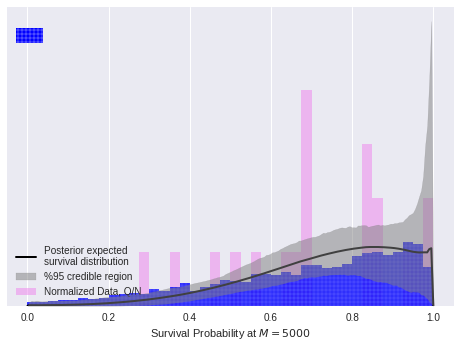

In [10]:
survival_dist_plot(fit_over,fit_over.data,surv_hatch='+++')

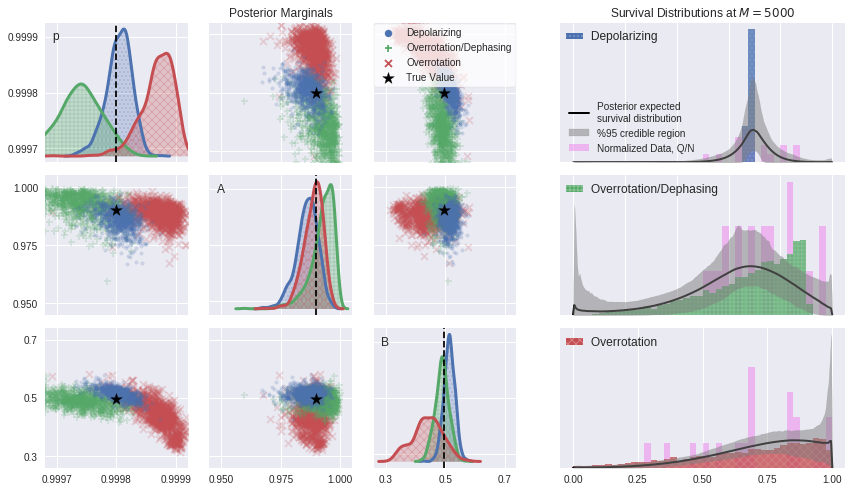

In [11]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(3,5, width_ratios=[1,1,1,0,2], height_ratios=[1,1,1]) 

fits = [fit_dep, fit_od, fit_over]
datas = [data_dep, data_od, data_over]
noise_models = ['Depolarizing','Overrotation/Dephasing','Overrotation']
fit_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
zorders = [100, 50, 1]
scatter_markers = ['.', '+', 'x']
true_vals = [0.9998,0.99,0.495]
names = ['p', 'A', 'B']
lims = np.array([(0.9997,.9999), (0.95,1), (0.3,0.7)])
elims = 0.1 * np.diff(lims) * np.array([-1,1]) + lims

def write_description(name, ax):
    label_loc=[0.05,0.9]
    ax.text(label_loc[0], label_loc[1], name,
        transform = ax.transAxes, va='center', ha='left'
    )

for idxx in range(3):
    for idxy in range(3):
        if idxx==idxy:
            idx=idxx
            plt.sca(plt.subplot(gs[idx, idx]))
            for idx_fit, fit in enumerate(fits):
                kde = sbn.kdeplot(
                    fit.extract()[names[idx]], 
                    lw=3, shade=True, 
                    color=fit_colors[idx_fit]
                )
                kde.collections[idx_fit].set_hatch(scatter_markers[idx_fit]*3)
                kde.collections[idx_fit].set_edgecolor(fit_colors[idx_fit])
            plt.axvline(true_vals[idx] ,linestyle='--', c='k',zorder=200)
            plt.xlim(elims[idx])
            write_description(names[idx], plt.gca())
        elif idxx != idxy:
            plt.sca(plt.subplot(gs[idxx, idxy]))
            for idx_fit, fit in enumerate(fits):
                plt.scatter(
                    fit.extract()[names[idxy]], 
                    fit.extract()[names[idxx]], 
                    marker=scatter_markers[idx_fit],
                    alpha=0.2, 
                    color=fit_colors[idx_fit],
                    zorder=zorders[idx_fit]
                )
            plt.scatter(true_vals[idxy], true_vals[idxx], c='k', marker='*', s=150, zorder=500)
            plt.xlim(elims[idxy])
            plt.ylim(elims[idxx])
        plt.yticks([])
        
        if idxx == 2:
            plt.xticks(np.linspace(*lims[idxy], num=3))
            #plt.xlabel(names[idxy])
        else:
            plt.xticks(np.linspace(*lims[idxy], num=3),['','',''])

        ax = plt.subplot(gs[idxx, idxy])
        plt.sca(ax)
        if idxy == 0:
            if idxx == idxy:
                x = ax.get_ylim()
                ax.set_yticks([x[0] + 0.1*(x[1]-x[0]),(x[0]+x[1])/2,x[1]-0.1*(x[1]-x[0])])
                ax.set_yticklabels(np.linspace(*lims[idxx], num=3))
            else:
                plt.yticks(np.linspace(*lims[idxx], num=3))
            #plt.ylabel(names[idxx])
        else:
            if idxx == idxy:
                x = ax.get_ylim()
                ax.set_yticks([x[0] + 0.1*(x[1]-x[0]),(x[0]+x[1])/2,x[1]-0.1*(x[1]-x[0])])
                ax.set_yticklabels(['','',''])
            else:
                plt.yticks(np.linspace(*lims[idxx], num=3), ['','',''])

plt.sca(plt.subplot(gs[0,1]))
plt.title('Posterior Marginals')
                

for idx in range(3):
    plt.sca(plt.subplot(gs[idx,4]))
    survival_dist_plot(fits[idx], datas[idx], surv_color=fit_colors[idx], surv_hatch=3*scatter_markers[idx])
    write_description(r'     {}'.format(noise_models[idx]), plt.gca())
    if idx == 0:
        plt.title('Survival Distributions at $M=5000$')
    if idx != 0:
        plt.legend([])
    if idx < 2:
        plt.gca().set_xticklabels([])
    plt.xlabel('')
plt.xticks(np.linspace(0,1,5))

plt.sca(plt.subplot(gs[0,2]))
lgnd = plt.legend(
    noise_models + ['True Value'],
    bbox_to_anchor=[1.03,1.03],
    loc=1
)
lgnd.legendHandles[0]._sizes = [200]
for idx in range(3):
    lgnd.legendHandles[idx].set_alpha(1)
lgnd.set_zorder(10000)
lgnd.set_frame_on(True)
lgnd.get_frame().set_facecolor('w')
plt.gca().set_zorder(1000)


plt.tight_layout()

/home/ihincks/.local/share/miniconda2/envs/birb/lib/python2.7/site-packages/matplotlib/gridspec.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


Overwriting ../fig/different-noise-models-summary.png
Overwriting ../fig/different-noise-models-summary.pdf


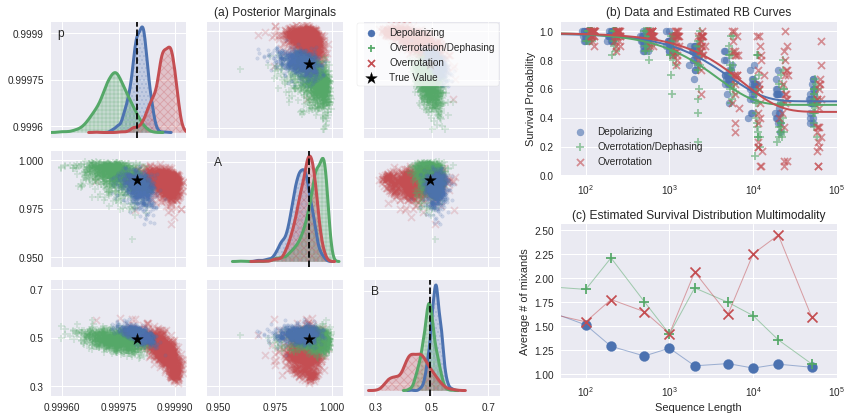

In [12]:
fig = plt.figure(figsize=(12,6))
w_ratio = 0.6
gs = gridspec.GridSpec(3,3, left=0, right=w_ratio *0.9, bottom=0,top=1) 
gs2 = gridspec.GridSpec(2,1, left=w_ratio * 1.1, right=1, bottom=0, top=1)

fits = [fit_dep, fit_od, fit_over]
datas = [data_dep, data_od, data_over]
noise_models = ['Depolarizing','Overrotation/Dephasing','Overrotation']
fit_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
zorders = [100, 50, 1]
scatter_markers = ['.', '+', 'x']
true_vals = [0.9998,0.99,0.495]
names = ['p', 'A', 'B']
lims = np.array([(0.9996,.9999), (0.95,1), (0.3,0.7)])
elims = 0.1 * np.diff(lims) * np.array([-1,1]) + lims

def write_description(name, ax):
    label_loc=[0.05,0.9]
    ax.text(label_loc[0], label_loc[1], name,
        transform = ax.transAxes, va='center', ha='left'
    )
    
#==========================================================================
# Posterior Pairs
#==========================================================================

for idxx in range(3):
    for idxy in range(3):
        if idxx==idxy:
            idx=idxx
            plt.sca(plt.subplot(gs[idx, idx]))
            for idx_fit, fit in enumerate(fits):
                kde = sbn.kdeplot(
                    fit.extract()[names[idx]], 
                    lw=3, shade=True, 
                    color=fit_colors[idx_fit]
                )
                kde.collections[idx_fit].set_hatch(scatter_markers[idx_fit]*3)
                kde.collections[idx_fit].set_edgecolor(fit_colors[idx_fit])
            plt.axvline(true_vals[idx] ,linestyle='--', c='k',zorder=200)
            plt.xlim(elims[idx])
            write_description(names[idx], plt.gca())
        elif idxx != idxy:
            plt.sca(plt.subplot(gs[idxx, idxy]))
            for idx_fit, fit in enumerate(fits):
                plt.scatter(
                    fit.extract()[names[idxy]], 
                    fit.extract()[names[idxx]], 
                    marker=scatter_markers[idx_fit],
                    alpha=0.2, 
                    color=fit_colors[idx_fit],
                    zorder=zorders[idx_fit]
                )
            plt.scatter(true_vals[idxy], true_vals[idxx], c='k', marker='*', s=150, zorder=500)
            plt.xlim(elims[idxy])
            plt.ylim(elims[idxx])
        plt.yticks([])
        
        if idxx == 2:
            plt.xticks(np.linspace(*lims[idxy], num=3))
            #plt.xlabel(names[idxy])
        else:
            plt.xticks(np.linspace(*lims[idxy], num=3),['','',''])

        ax = plt.subplot(gs[idxx, idxy])
        plt.sca(ax)
        if idxy == 0:
            if idxx == idxy:
                x = ax.get_ylim()
                ax.set_yticks([x[0] + 0.1*(x[1]-x[0]),(x[0]+x[1])/2,x[1]-0.1*(x[1]-x[0])])
                ax.set_yticklabels(np.linspace(*lims[idxx], num=3))
            else:
                plt.yticks(np.linspace(*lims[idxx], num=3))
            #plt.ylabel(names[idxx])
        else:
            if idxx == idxy:
                x = ax.get_ylim()
                ax.set_yticks([x[0] + 0.1*(x[1]-x[0]),(x[0]+x[1])/2,x[1]-0.1*(x[1]-x[0])])
                ax.set_yticklabels(['','',''])
            else:
                plt.yticks(np.linspace(*lims[idxx], num=3), ['','',''])

plt.sca(plt.subplot(gs[0,1]))
plt.title('(a) Posterior Marginals')

plt.sca(plt.subplot(gs[0,2]))
lgnd = plt.legend(
    noise_models + ['True Value'],
    bbox_to_anchor=[1.03,1.03],
    loc=1
)
lgnd.legendHandles[0]._sizes = [200]
for idx in range(3):
    lgnd.legendHandles[idx].set_alpha(1)
lgnd.set_zorder(10000)
lgnd.set_frame_on(True)
lgnd.get_frame().set_facecolor('w')
plt.gca().set_zorder(1000)

#==========================================================================
# Predictive fits
#==========================================================================
  

    
plt.sca(plt.subplot(gs2[0,0]))

ms = 10**np.linspace(1, np.log10(2*datas[0]['m'].max()), 200)
def rb_curve(p, A, B):
    return (A - B) * p**ms + B

for idx_fit, fit in enumerate(fits):
    Nm = fit.data['Nm']
    Nsamp = fit.data['Nsamp']
    Nbin = float(fit.data['Nbin'])
    mlist = fit.data['m']
    for idx_m in range(Nm):

        plt.scatter(
            mlist[idx_m] + 0.05 * mlist[idx_m]* (np.random.randn(Nsamp) + 2*idx_fit),
            fit.data['Q'][idx_m,:] / Nbin,
            c=fit_colors[idx_fit],
            alpha=0.6,
            marker=scatter_markers[idx_fit],
            label= '' if idx_m > 0 else noise_models[idx_fit],
            s=200 if idx_fit==0 else 50
        )
    mean = [np.mean(fit.extract()[field][:]) for field in ['p', 'A', 'B']]
    plt.plot(
        ms, rb_curve(*mean),
        color = fit_colors[idx_fit],
        linewidth=2
    )

plt.xlim([50,1e5])
plt.xscale('log', basex=10)
#plt.xlabel('Sequence Length')
plt.legend(loc=3)
plt.ylabel('Survival Probability')
plt.title('(b) Data and Estimated RB Curves')
    
#==========================================================================
# Posterior Pairs
#==========================================================================
                
plt.sca(plt.subplot(gs2[1,0]))

def n_eff_modes(fit):
    w = fit.extract()['w']
    return np.mean(1 / np.sum(w **2, axis=2), axis=0)

for idx_fit, fit in enumerate(fits):
    plt.plot(fit.data['m'], n_eff_modes(fit), color=fit_colors[idx_fit], linewidth=1, alpha=0.5)
    plt.scatter(
        fit.data['m'], 
        n_eff_modes(fit),
        color=fit_colors[idx_fit], 
        marker=scatter_markers[idx_fit],
        s=400 if idx_fit==0 else 100
    )
    plt.xscale('log', base=10)
    plt.xlim([50,1e5])

plt.ylabel('Average # of mixands')
plt.xlabel('Sequence Length')
plt.title('(c) Estimated Survival Distribution Multimodality')
    
#==========================================================================
# Epilog
#==========================================================================



gs2.tight_layout(fig, rect=[w_ratio, 0, 1, 1])
gs.tight_layout(fig, rect=[0, 0, w_ratio, 1])

su.export_figure(fig, 'different-noise-models-summary')

## Bootstrapped Distributions

In [13]:
bootstrap_dep = su.bootstrap_ABpv_mle(data_dep, 2000, sampler=su.bootstrap_nonparam_sample)
bootstrap_over = su.bootstrap_ABpv_mle(data_over, 2000, sampler=su.bootstrap_nonparam_sample)
bootstrap_od = su.bootstrap_ABpv_mle(data_od, 2000, sampler=su.bootstrap_nonparam_sample)

utils.py:392: RuntimeWarning: divide by zero encountered in divide
  jac[...,1,0] = -mu / v**2
utils.py:393: RuntimeWarning: divide by zero encountered in divide
  jac[...,1,1] = (mu - 1) / v**2
utils.py:373: RuntimeWarning: invalid value encountered in subtract
  - gammaln(k + 1) - gammaln(n - k + 1) - gammaln(n + a + b) - gammaln(a) - gammaln(b)
utils.py:362: RuntimeWarning: divide by zero encountered in divide
  harmonic_sum = np.cumsum(1 / (z[...,np.newaxis] + np.arange(0, max_k)), axis=-1)
utils.py:447: RuntimeWarning: invalid value encountered in multiply
  jac[3:] = jac1_r * jac2[:,1,0]
utils.py:422: RuntimeWarning: divide by zero encountered in divide
  a = mus * (1 / vs - 1)
utils.py:423: RuntimeWarning: divide by zero encountered in divide
  b = (1 - mus) * (1 - vs) / vs
utils.py:390: RuntimeWarning: divide by zero encountered in divide
  jac[...,0,0] = 1 / v - 1
utils.py:376: RuntimeWarning: invalid value encountered in subtract
  common = psi(s) - psi(s + n)
utils.py:423: R

/home/ihincks/.local/share/miniconda2/envs/birb/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


Overwriting ../fig/different-noise-models-bootstrap.png
Overwriting ../fig/different-noise-models-bootstrap.pdf


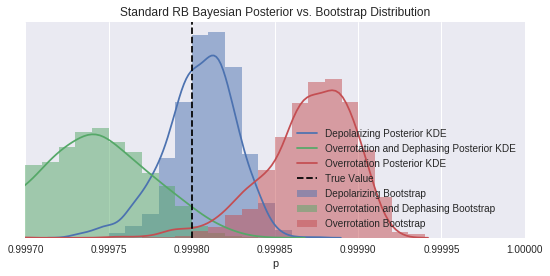

In [14]:
fig = plt.figure(figsize=(7.8,4))

fit_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

sbn.kdeplot(fit_dep.extract()['p'][:], label='Depolarizing Posterior KDE', c=fit_colors[0])
sbn.kdeplot(fit_od.extract()['p'][:], label='Overrotation and Dephasing Posterior KDE', c=fit_colors[1])
sbn.kdeplot(fit_over.extract()['p'][:], label='Overrotation Posterior KDE', c=fit_colors[2])

plt.hist(bootstrap_dep[:,2], bins=50,range=[0.9995,1], alpha=0.5, normed=True, label='Depolarizing Bootstrap', facecolor=fit_colors[0])
plt.hist(bootstrap_od[:,2], bins=50,range=[0.9995,1], alpha=0.5, normed=True, label='Overrotation and Dephasing Bootstrap', facecolor=fit_colors[1])
plt.hist(bootstrap_over[:,2], bins=50,range=[0.9995,1], alpha=0.5, normed=True, label='Overrotation Bootstrap', facecolor=fit_colors[2])

plt.axvline(0.9998,linestyle='--', c='k', label='True Value')
plt.yticks([])
plt.legend()
plt.xlim([0.9997,1])
plt.title('Standard RB Bayesian Posterior vs. Bootstrap Distribution')
plt.xlabel('p')

plt.tight_layout()

su.export_figure(fig, 'different-noise-models-bootstrap')

## Beta Model Stan Model

The same as the dirichlet process section, but now we load in the beta-model instead.

In [17]:
model_beta = su.StanModelFactory('./stan/rb-beta-r.stan').model

In [18]:
fname = data_dep['fname']
data_dep.pop('fname')
fit_dep_beta = model_beta.sampling(data=data_dep, iter=2000, chains=4)
data_dep['fname'] = fname

In [23]:
fname = data_od['fname']
data_od.pop('fname')
fit_od_beta = model_beta.sampling(data=data_od, iter=2000, chains=4)
data_od['fname'] = fname

In [20]:
fname = data_over['fname']
data_over.pop('fname')
fit_over_beta = model_beta.sampling(data=data_over, iter=2000, chains=4)
data_over['fname'] = fname

(0.9996, 1)

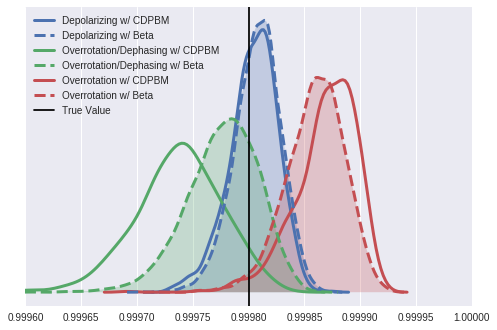

In [24]:
fits = [fit_dep, fit_od, fit_over]
fits_beta = [fit_dep_beta, fit_od_beta, fit_over_beta]
noise_models = ['Depolarizing','Overrotation/Dephasing','Overrotation']
fit_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
zorders = [100, 50, 1]
scatter_markers = ['.', '+', 'x']

for idx, fit in enumerate(fits):
    sbn.kdeplot(
        fit.extract()['p'], 
        label='{} w/ CDPBM'.format(noise_models[idx]), 
        color=fit_colors[idx],
        linewidth=3
    )
for idx, fit in enumerate(fits_beta):
    sbn.kdeplot(
        fit.extract()['p'], 
        label='{} w/ Beta'.format(noise_models[idx]), 
        color=fit_colors[idx], 
        linestyle='--',
        linewidth=3,
        shade=True
    )
    
plt.axvline(0.9998 ,linestyle='-', c='k',zorder=200, label='True Value')
    
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,4,2,5,6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=2)
plt.yticks([])
plt.xlim([0.9996,1])

In [25]:
def survival_dist_plot_comp(fit, fit_beta, bootstrap, data, m=5000, surv_color='b', surv_hatch='', xlim=(0,1), description=None):
    idx_m = int(np.arange(data['Nm'])[data['m'] == m])

    w = fit.extract()['w'][:,idx_m,np.newaxis,:]
    nu = fit.extract()['nu'][:,idx_m,np.newaxis,:]
    r = fit.extract()['r'][:,idx_m,np.newaxis,:]
    a = 1 / (r - r * nu) - nu
    b = 1 / (r * nu) - 1 + nu

    x_plot = np.linspace(0, 1, 200)
    post_pmfs = np.sum(w * st.beta.pdf(np.atleast_3d(x_plot), a, b), axis=2)
    post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)
    plt.fill_between(x_plot, post_pmf_low, post_pmf_high, color='gray', alpha=0.3, zorder=50)
    plt.plot(x_plot, post_pmfs.mean(axis=0), lw=3, c='k', linestyle='--', zorder=100, label='CDPBM: Posterior expected \nsurvival distribution')
    
    A, B, p = [bootstrap[:,idx] for idx in range(3)]
    mus = (A - B)* p ** m + B
    vs = bootstrap[:,3 + idx_m]
    a = mus * (1 / vs - 1)
    b = (1 - mus) * (1 - vs) / vs
    bootstrap_pmfs = st.beta.pdf(x_plot[np.newaxis,:], a[:,np.newaxis], b[:,np.newaxis])
    bootstrap_pmf_low, bootstrap_pmf_high = np.percentile(bootstrap_pmfs, [2.5, 97.5], axis=0)
    plt.fill_between(x_plot, bootstrap_pmf_low, bootstrap_pmf_high, color='orange', alpha=0.3, zorder=50)
    plt.plot(x_plot, bootstrap_pmfs.mean(axis=0), lw=3, c='orange', linestyle=':', zorder=101, label='Bootstrap estimates')
    
    a = fit_beta.extract()['a'][:,idx_m,np.newaxis]
    b = fit_beta.extract()['b'][:,idx_m,np.newaxis]
    post_pmfs = st.beta.pdf(x_plot[np.newaxis,:], a, b)
    post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)
    plt.fill_between(x_plot, post_pmf_low, post_pmf_high, color='skyblue', alpha=0.3, zorder=50)
    plt.plot(x_plot, post_pmfs.mean(axis=0), lw=3, c='skyblue', zorder=102, label='Beta: Posterior expected \nsurvival distribution')
    
    rbd = su.RBSimData(data['fname'])
    survivals = rbd.survival_data[idx_m,0,:,0]
    plt.hist(data['Q'][idx_m,:] / float(data['Nbin']), normed=True, color='violet', bins=40, range=xlim, alpha=0.5, label='Normalized Data, Q/N')
    plt.hist(survivals, normed=True, bins=40, range=xlim, alpha=0.8, color=surv_color, hatch=surv_hatch, linewidth=0, edgecolor=su.lighten_color(surv_color,0.7))


    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,2,1,3]
    plt.ylim([0, 1.0 * plt.gca().get_ylim()[1]])
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=3)
    plt.yticks([])
    plt.xlabel('Survival Probability at $M={}$'.format(m))
    if description is not None:
        write_description(r'     {}'.format(description), plt.gca())
        plt.gca().add_patch(plt.Rectangle(
            (0.02,0.88), 0.06,0.05, 
            zorder=2000, 
            transform=plt.gca().transAxes, 
            facecolor=surv_color, 
            hatch=surv_hatch, linewidth=0, 
            edgecolor=su.lighten_color(surv_color,0.7)
        ))
    
    plt.xlim(xlim)

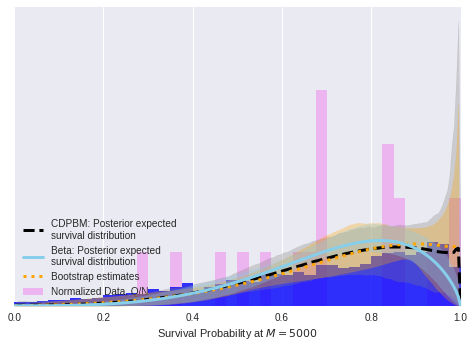

In [31]:
survival_dist_plot_comp(fit_over, fit_over_beta, bootstrap_over, data_over)

/home/ihincks/.local/share/miniconda2/envs/birb/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in divide
/home/ihincks/.local/share/miniconda2/envs/birb/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in divide
/home/ihincks/.local/share/miniconda2/envs/birb/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Overwriting ../fig/different-noise-models-survival-dists.png
Overwriting ../fig/different-noise-models-survival-dists.pdf


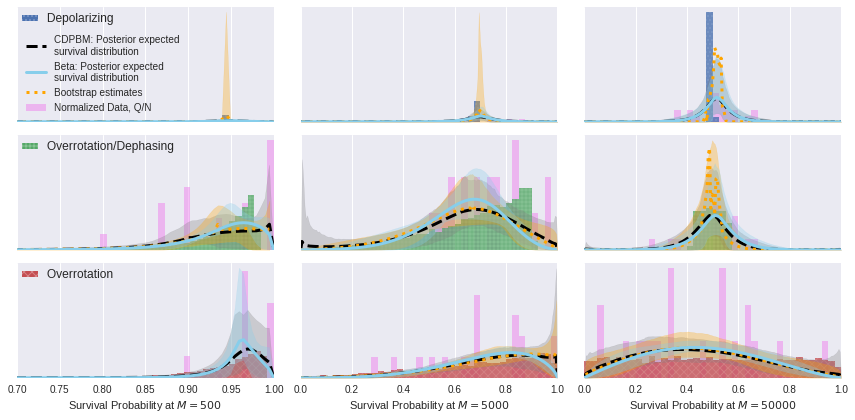

In [37]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(3,3, width_ratios=[1,1,1], height_ratios=[1,1,1]) 

fits = [fit_dep, fit_od, fit_over]
fits_beta = [fit_dep_beta, fit_od_beta, fit_over_beta]
bootstraps = [bootstrap_dep, bootstrap_od, bootstrap_over]
datas = [data_dep, data_od, data_over]
noise_models = ['Depolarizing','Overrotation/Dephasing','Overrotation']
fit_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scatter_markers = ['.', '+', 'x']
xlims = [(0.7,1),(0,1),(0,1)]

for idx_m, m in enumerate([500,5000,50000]):
    for idx_fit in range(3):
        fit = fits[idx_fit]
        fit_beta = fits_beta[idx_fit]
        plt.sca(plt.subplot(gs[idx_fit, idx_m]))
        survival_dist_plot_comp(
            fit, fit_beta, bootstraps[idx_fit],
            datas[idx_fit], m=m, 
            surv_color=fit_colors[idx_fit], 
            surv_hatch=3*scatter_markers[idx_fit],
            xlim = xlims[idx_m],
            description = None if idx_m > 0 else noise_models[idx_fit]
        )
        if idx_fit < 2:
            plt.gca().set_xticklabels([])
            plt.xlabel('')
        if idx_fit != 0 or idx_m != 0:
            plt.legend([])
            
        
plt.tight_layout()
su.export_figure(fig, 'different-noise-models-survival-dists')

Overwriting ../fig/different-noise-models-comparison.png
Overwriting ../fig/different-noise-models-comparison.pdf


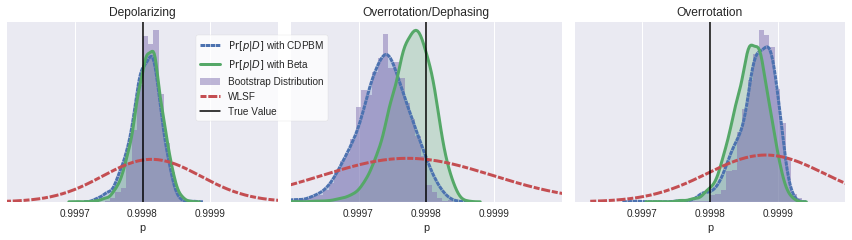

In [38]:
def p_comparison(fit, fit_beta, bootstrap_dist, data):
    sbn.kdeplot(fit.extract()['p'], lw=3, shade=True, label='$\operatorname{Pr}[p|D]$ with CDPBM')
    out = sbn.kdeplot(fit_beta.extract()['p'], lw=3, shade=True, label='$\operatorname{Pr}[p|D]$ with Beta')
    out.lines[0].set_linestyle((0,[1.5,.2]))

    lsf_est, lsf_cov, f_std_ests = su.rb_naive_wlsf(data)
    p_est, p_std_est = lsf_est[0], np.sqrt(lsf_cov[0,0])
    x = np.linspace(p_est-p_std_est*3,p_est+p_std_est*3,200)
    y = st.norm.pdf(x, loc=p_est, scale=p_std_est)
    plt.plot(x,y,lw=3,ls=(0,(2,.6,3,.6)),label='WLSF')
    
    plt.hist(
        bootstrap_dist[:,2], 
        bins=50, 
        range=(0.9996,1),
        normed=True, 
        alpha=0.5,
        label='Bootstrap Distribution'
    )

#     lsf_est, lsf_cov, _ = su.rb_lsf(data)
#     p_est, p_std_est = lsf_est[0], np.sqrt(lsf_cov[0,0])
#     plt.axvline(x=p_est, color='purple', ls='-.',label='LSF Estimate')

    plt.axvline(x=0.9998, color='k', lw=1.5, label='True Value')
    plt.legend(loc=2)
    plt.yticks([])
    plt.xlim([0.9996,1])
    plt.xticks([0.9997,0.9998,0.9999])
    plt.xlabel('p') 

fig = plt.figure(figsize=(12,3.5))
gs = gridspec.GridSpec(1,3)

fits = [fit_dep, fit_od, fit_over]
fits_beta = [fit_dep_beta, fit_od_beta, fit_over_beta]
bootstraps = [bootstrap_dep, bootstrap_od, bootstrap_over]
datas = [data_dep, data_od, data_over]
noise_models = ['Depolarizing','Overrotation/Dephasing','Overrotation']

for idx in range(3):
    plt.sca(plt.subplot(gs[idx]))
    p_comparison(fits[idx], fits_beta[idx], bootstraps[idx], datas[idx])
    plt.title('{}'.format(noise_models[idx]))
    h, l = plt.gca().get_legend_handles_labels()
    plt.legend([])

plt.sca(plt.subplot(gs[1]))
order = [0,1,4,2,3]
legend = plt.legend([h[idx] for idx in order],[l[idx] for idx in order], 
           bbox_to_anchor=(-0.35, 0.45), loc='lower left', borderaxespad=0., frameon=True)
legend.get_frame().set_facecolor('#FFFFFF')

gs.tight_layout(fig)
su.export_figure(fig, 'different-noise-models-comparison')